## Сегментация изображение (удаление фона) с использованием OpenCV

### Алгоритм:
- Шаг 1: Выделение границ применением оператора Собеля  
- Шаг 2: Удаление шума на полученном изображении  
- Шаг 3: Определение контуров предметов и выбор наиболее значимых 
- Шаг 4: Создание и применение маски  

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

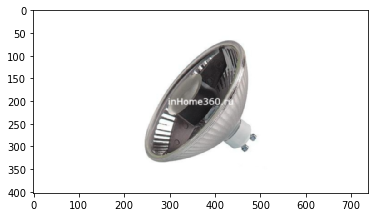

In [2]:
# Считываем изоражение и удаляем шум
img = cv2.imread("example.jpg")
blurred = cv2.GaussianBlur(img, (5, 5), 0)

plt.imshow(blurred)
plt.show()

### Шаг 1: Выделение границ применением оператора Собеля

In [3]:
def edge_detect (channel):
    """
    Вспомогательная функция для определения границ
    
    @param channel: одна цветовая компонента изображения
    @return sobel: результат применения к ней операторов Собеля по x и y 
    
    """
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0, cv2.BORDER_CONSTANT)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1, cv2.BORDER_CONSTANT)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel

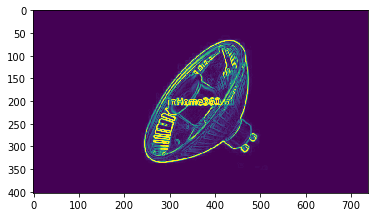

In [4]:
edge_img = np.max(np.array([
        edge_detect(blurred[:, :, 0]), 
        edge_detect(blurred[:, :, 1]), 
        edge_detect(blurred[:, :, 2])]), 
    axis=0)

plt.imshow(edge_img)

### Шаг 2: Удаление шума

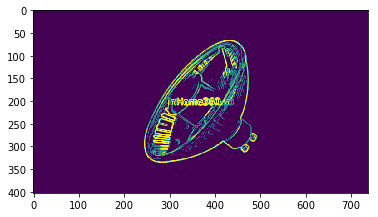

In [5]:
# Параметр shift влияет на качество работы (размер области)
shift = np.std(edge_img)
mean_img = np.mean(edge_img) + shift
edge_img[edge_img <= mean_img] = 0

plt.imshow(edge_img)

### Шаг 3: Определение контуров предметов

In [6]:
def find_significant_contours(img, edge_img):
    """
    Вспомогательная функция для нахождения главных контуров на изображении
    
    @param img: исходное изображение
    @param edge_img: изображение с выделенными границами
    @return sirted_conoutrs: главные контуры (list of np.array)
    
    """
    
    image, contours, heirarchy = cv2.findContours(edge_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            level1.append(tupl)

    significant = []
    too_small = edge_img.size * 5 / 100
    
    # Если контур не покрывает 5% всего изоражения, то не будем его учитывать
    for tupl in level1:
        contour = contours[tupl[0]];
        area = cv2.contourArea(contour)
        if area > too_small:
            significant.append([contour, area])

            # Избразим контуры на исходном изображении
            cv2.drawContours(img, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)

    significant.sort(key=lambda x: x[1])
    sorted_contours = [x[0] for x in significant]
    return sorted_contours

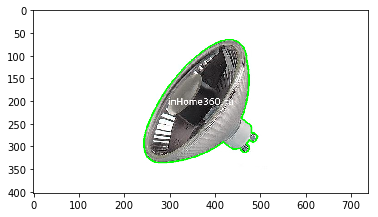

In [7]:
edge_img_8u = np.asarray(edge_img, np.uint8)
significant = find_significant_contours(img, edge_img_8u)

plt.imshow(img)

### Шаг 4: Создание и применение маски

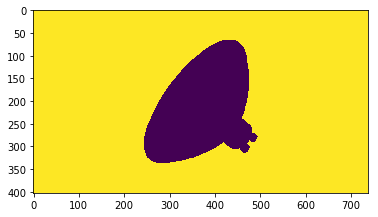

In [8]:
# Определение маски
mask = edge_img.copy()
mask[mask > 0] = 0
cv2.fillPoly(mask, significant, 255)

# Инвертирование маски
mask = np.logical_not(mask)

plt.imshow(mask)

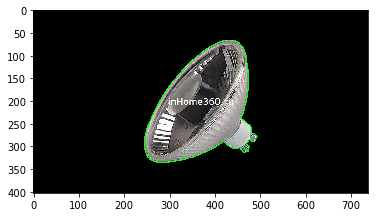

In [10]:
# Удаляем фон
img[mask] = 0

from copy import deepcopy

white_img = deepcopy(img)

# И добавляем контуры на изображение
epsilon = 0.10 * cv2.arcLength(significant[0], True)
approx = cv2.approxPolyDP(significant[0], epsilon, True)
contour = approx
cv2.drawContours(img, contour, -1, (0, 255, 0), 3)

plt.imshow(img)

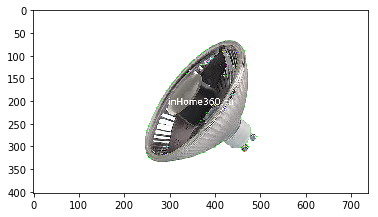

In [11]:
# Белый фон
white_img[white_img == 0] = 255

plt.imshow(white_img)